In [82]:
# 01_read_log

In [83]:
# Force to reload extrernal modules every new cell execution
%reload_ext autoreload
%autoreload 2

In [84]:
### IMPORT ###
from pathlib import Path
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [85]:
### LOCAL IMPORT ###
from config import config_reader
from utilities import convert_seconds_to_hours, find_min_max_timestamp

In [86]:
### GLOBALS ###
yaml_config = config_reader.config_read_yaml("config.yml", "config")
log_dir = str(yaml_config["LOG_DIR"])
stats_dir = str(yaml_config["STATS_DIR"])

log_in = "EVENT-LOG_ED.csv" # <-- INPUT: initial event log
dic_types = {"CaseID":object, "ACTIVITY":object, "TIMESTAMP":object, "RESOURCE":object, "ESI": int, "OUTCOME":object, "INPAT-HOSP-DEP":object} # <-- INPUT: event log columns types

# FUNCTIONS

In [87]:
def calculate_durations(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """
    Calculate the total duration of each process and the remaining time for each event (in seconds).

    Parameters:
    df (pd.DataFrame): A DataFrame containing a timestamp column and a 'CaseID' column for grouping.
    col_name (str): The name of the column that contains the timestamp values.

    Returns:
    pd.DataFrame: The input DataFrame with additional columns for 'CASE_DURATION' and 'REMAINING_TIME'.
    """
    
    # Convert the timestamp column to datetime
    df[col_name] = pd.to_datetime(df[col_name])
    
    # Calculate the total duration of the process for each CaseID
    df['CASE_DURATION_sec'] = df.groupby('CaseID')[col_name].transform(lambda x: (x.max() - x.min()).total_seconds())
    
    # Calculate the remaining time for each row
    df['REMAINING_TIME_sec'] = df.groupby('CaseID')[col_name].transform(lambda x: (x.max() - x).dt.total_seconds())
    
    return df

In [88]:
def unique_caseid_value_distribution(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """
    Calculate the distribution of unique values for a specified column for each distinct 'CaseID',
    and include the count and percentage of each value with respect to the total.

    Parameters:
    df (pd.DataFrame): DataFrame containing the columns 'CaseID' and the specified column.
    col_name (str): The name of the column for which to calculate the distribution.

    Returns:
    pd.DataFrame: DataFrame showing the count and percentage of unique values for the specified column for unique 'CaseID'.
    """
    # Keep only the last occurrence of each CaseID
    unique_caseid_df = df.drop_duplicates(subset='CaseID', keep='last')
    
    # Calculate the distribution of the specified column values
    value_counts = unique_caseid_df[col_name].value_counts()
    value_percentages = (value_counts / value_counts.sum() * 100).round(2)
    
    # Combine counts and percentages into a single DataFrame
    value_distribution = pd.DataFrame({
        'Count': value_counts,
        'Percentage': value_percentages
    })
    
    return value_distribution

In [89]:
def plot_esi_distribution(dataframe: pd.DataFrame) -> None:
    """
    This function takes a dataframe as input and plots the distribution of ESI levels.
    
    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing an 'ESI' column.
    """
    # Calculate the distribution of ESI levels
    esi_distribution = dataframe['ESI'].value_counts().sort_index()

    # Plot the distribution
    plt.figure(figsize=(10, 6))
    esi_distribution.plot(kind='bar', color='skyblue')
    plt.title('Distribution of ESI values')
    plt.xlabel('ESI Level')
    plt.ylabel('Frequency')
    plt.xticks(rotation=0)
    plt.grid(axis='y')

    # Show the plot
    plt.show()

# MAIN

In [90]:
### MAIN ###
print()
print("*** PROGRAM START ***")
print()

start_time = datetime.now().replace(microsecond=0)
print("Start process:", str(start_time))
print()

# print(yaml_config) # debug


*** PROGRAM START ***

Start process: 2024-08-03 12:58:36



In [91]:
print(">> Creating output directories")
directory_path = Path(stats_dir) # <-- Specify the directory to be created
# Create the directory
directory_path.mkdir(parents=True, exist_ok=True)
print(f"Directory '{directory_path}' created successfully.")

>> Creating output directories
Directory 'stats' created successfully.


In [92]:
print(">> Reading initial event log")
path_data = Path(log_dir) / log_in
print("File:", path_data)
df_log = pd.read_csv(path_data, sep=",", dtype=dic_types)
print("Event log shape:", df_log.shape)
print("Event log cases:", df_log["CaseID"].nunique())
print()
print("> Distinct values")
for col_name in df_log.columns:
    if col_name == "TIMESTAMP" or col_name == "CaseID":
        continue
    print("Column:", col_name)
    data_list = sorted(df_log[col_name].unique().tolist())
    data_list_len = len(data_list)
    print(f"Column data uniquie values ({data_list_len}): {data_list}")
    print()
# Time span
dic_min_max_t = find_min_max_timestamp(df_log, "TIMESTAMP")
print(f"Minimum TIMESTAMP value: {dic_min_max_t["min_timestamp"]}")
print(f"Maximum TIMESTAMP value: {dic_min_max_t["max_timestamp"]}")
print()
# Type of RESOURCE
doc_distinct_count = df_log[df_log['RESOURCE'].str.startswith('DOC')]['RESOURCE'].nunique()
nur_distinct_count = df_log[df_log['RESOURCE'].str.startswith('NUR')]['RESOURCE'].nunique()
print(f"Number of 'DOC': {doc_distinct_count}")
print(f"Number of 'NUR': {nur_distinct_count}")
print()


>> Reading initial event log
File: data_log/EVENT-LOG_ED.csv
Event log shape: (20624, 7)
Event log cases: 3478

> Distinct values
Column: ACTIVITY
Column data uniquie values (60): ['ALTRA INTUBAZIONE DEL TRATTO RESPIRATORIO (INSERZIONE STENT)', 'ALTRI INTERVENTI SULLA TRACHEA', 'ARCATA DENTARIA COMPLETA (SUP O INF)', 'ASPORTAZIONE O DEMOLIZIONE ENDOSCOPICA DI LESIONE O TESSUTO NEI BRONCHI', 'BICARBONATO DIALISI', 'BIOPSIA LINFONODO', 'BIOPSIA/CITOLOGIA BRONCHIALE', 'BRONCOSCOPIA CON FIBRE OTTICHE', 'BRONCOSCOPIA RIGIDA', 'COLONSCOPIA CON ENDOSCOPIO FLESSIBILE', 'CONSULENZA', 'CONTROLLI PRETRASF.', 'CONTROLLO NEFROLOGICO', 'CONTROLLO PM-ICD-LOOP', 'DIMISSIONE', 'ECG', 'ECO-DOPPLER ARTERIOSO ARTI INF.', 'ECO-DOPPLER TRONCHI SOVRAORTICI', 'ECO-DOPPLER VENOSO ARTI INF.', 'ECOGRAF.ADDOME COMPLETO', 'ECOGRAF.RENOVESCICALE', 'ECOGRAFIA ADDOME INFERIORE', 'ECOGRAFIA ADDOME SUP.', 'ECOGRAFIA CUTE E TESSUTO', 'ECOGRAFIA MUSCOLO TENDINEA', 'ECOGRAFIA PENIENA', 'ECOGRAFIA SCROTALE/TESTICOLARE', 'E

In [93]:
print(">> Stats")
# Value frequencies
list_col_name = ["OUTCOME", "INPAT-HOSP-DEP"]
for col_name in list_col_name:
    print("> Column:", col_name)
    df_freq = unique_caseid_value_distribution(df_log, col_name)
    print(df_freq)
    file_out = f"{col_name}_stats.csv"
    path_out = Path(stats_dir) / file_out
    df_freq.to_csv(path_out, sep=";", quoting=csv.QUOTE_NONNUMERIC)
    print("-"*8)
    print()

>> Stats
> Column: OUTCOME
                                                  Count  Percentage
OUTCOME                                                            
A domicilio                                        2807       80.71
Ricoverato                                          456       13.11
Non risponde a chiamata                             106        3.05
Chiede di essere dimessa contro il parere medico     34        0.98
Si allontana senza consenso medico                   24        0.69
Trasferito in altra struttura di ricovero            22        0.63
Deceduto in P.S.                                     12        0.35
Rientro in Reparto                                    9        0.26
Rifiuta ricovero                                      6        0.17
Trasferito in altra struttura RSA - RAF ecc           1        0.03
Inserito per errore                                   1        0.03
--------

> Column: INPAT-HOSP-DEP
                                                 Count

In [94]:
print(">> Case duration and remaining time")
df_log_new = calculate_durations(df_log, "TIMESTAMP")

>> Case duration and remaining time


In [95]:
df_log_new

,CaseID,ACTIVITY,TIMESTAMP,RESOURCE,ESI,OUTCOME,INPAT-HOSP-DEP,CASE_DURATION_sec,REMAINING_TIME_sec
0,2022090001,TRIAGE,2022-09-01 00:03:55,NURS_0,3,A domicilio,-,41105.0,41105.0
1,2022090001,PRESA IN CARICO,2022-09-01 00:22:00,DOCT_0,3,A domicilio,-,41105.0,40020.0
2,2022090001,LABORATORIO,2022-09-01 00:28:21,-,3,A domicilio,-,41105.0,39639.0
3,2022090001,TC CRANIO,2022-09-01 00:38:00,-,3,A domicilio,-,41105.0,39060.0
4,2022090001,TAC,2022-09-01 00:38:00,-,3,A domicilio,-,41105.0,39060.0
...,...,...,...,...,...,...,...,...,...
20619,2022093478,DIMISSIONE,2022-10-01 00:21:00,-,3,A domicilio,-,2562.0,0.0
20620,2022093479,TRIAGE,2022-09-30 23:58:38,NURS_8,4,A domicilio,-,27322.0,27322.0
20621,2022093479,PRESA IN CARICO,2022-10-01 00:51:00,DOCT_1,4,A domicilio,-,27322.0,24180.0
20622,2022093479,LABORATORIO,2022-10-01 01:00:12,-,4,A domicilio,-,27322.0,23628.0


>> Distribution of ESI values


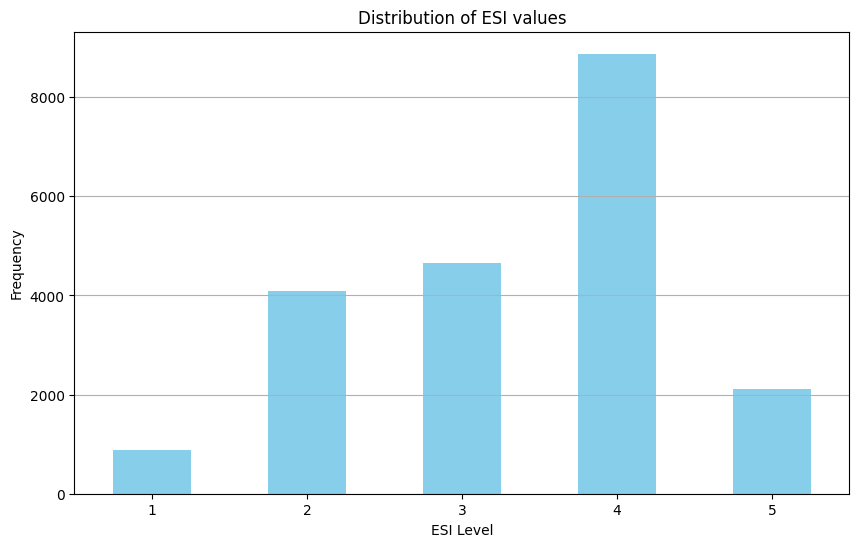

In [96]:
print(">> Distribution of ESI values")
plot_esi_distribution(df_log_new)

In [97]:
print(">> Checking TRIAGE and DIMISSIONE counts")

# Counting the number of 'TRIAGE' and 'DIMISSIONE'
num_triage = df_log_new[df_log_new['ACTIVITY'] == 'TRIAGE'].shape[0]
num_dimissione = df_log_new[df_log_new['ACTIVITY'] == 'DIMISSIONE'].shape[0]

# Check whether there are any CaseIDs without a corresponding 'DIMISSIONE'.
case_ids_with_triage = set(df_log_new[df_log_new['ACTIVITY'] == 'TRIAGE']['CaseID'])
case_ids_with_dimissione = set(df_log_new[df_log_new['ACTIVITY'] == 'DIMISSIONE']['CaseID'])

# CaseID without a corresponding 'DIMISSION'
case_ids_without_dimissione = case_ids_with_triage - case_ids_with_dimissione

num_triage, num_dimissione, len(case_ids_without_dimissione), list(case_ids_without_dimissione)[:10]

print("TRIAGE:", num_triage)
print("DIMISSIONE:", num_dimissione)
print(f"CASES without DIMISSIONE ({len(case_ids_without_dimissione)}): {list(case_ids_without_dimissione)[:10]}")

>> Checking TRIAGE and DIMISSIONE counts
TRIAGE: 3478
DIMISSIONE: 3478
CASES without DIMISSIONE (0): []


In [98]:
df_log_new

,CaseID,ACTIVITY,TIMESTAMP,RESOURCE,ESI,OUTCOME,INPAT-HOSP-DEP,CASE_DURATION_sec,REMAINING_TIME_sec
0,2022090001,TRIAGE,2022-09-01 00:03:55,NURS_0,3,A domicilio,-,41105.0,41105.0
1,2022090001,PRESA IN CARICO,2022-09-01 00:22:00,DOCT_0,3,A domicilio,-,41105.0,40020.0
2,2022090001,LABORATORIO,2022-09-01 00:28:21,-,3,A domicilio,-,41105.0,39639.0
3,2022090001,TC CRANIO,2022-09-01 00:38:00,-,3,A domicilio,-,41105.0,39060.0
4,2022090001,TAC,2022-09-01 00:38:00,-,3,A domicilio,-,41105.0,39060.0
...,...,...,...,...,...,...,...,...,...
20619,2022093478,DIMISSIONE,2022-10-01 00:21:00,-,3,A domicilio,-,2562.0,0.0
20620,2022093479,TRIAGE,2022-09-30 23:58:38,NURS_8,4,A domicilio,-,27322.0,27322.0
20621,2022093479,PRESA IN CARICO,2022-10-01 00:51:00,DOCT_1,4,A domicilio,-,27322.0,24180.0
20622,2022093479,LABORATORIO,2022-10-01 01:00:12,-,4,A domicilio,-,27322.0,23628.0


In [99]:
print(">> Event log stats")
df_log_new_stats = df_log_new.drop_duplicates(subset=["CaseID"])
case_duration_mean_sec = df_log_new_stats["CASE_DURATION_sec"].mean().round(3)
case_duration_median_sec = df_log_new_stats["CASE_DURATION_sec"].median().round(3)
case_dur_m, case_dur_h = convert_seconds_to_hours(case_duration_mean_sec)
print("Average case duration (sec):", case_duration_mean_sec)
print("Median case duration (sec):", case_duration_median_sec)
print("Average case duration (min):", case_dur_m.round(3))
print("Average case duration (hours):", case_dur_h.round(3))

df_log_new['TIMESTAMP'] = pd.to_datetime(df_log_new['TIMESTAMP'])
df_log_new['DATE'] = df_log_new['TIMESTAMP'].dt.date
distinct_case_per_day = df_log_new.groupby('DATE')['CaseID'].nunique()
average_distinct_case_per_day = distinct_case_per_day.mean().round(2)
print("Avarage CaseID per day:", average_distinct_case_per_day)

>> Event log stats
Average case duration (sec): 27610.9
Median case duration (sec): 10126.0
Average case duration (min): 460.182
Average case duration (hours): 7.67
Avarage CaseID per day: 128.12


In [100]:
print(">> Saving event log with new features")
log_out = f"{Path(log_in).stem}_duration.csv"
path_out = Path(log_dir) / log_out
print("File:", path_out)
df_log_new.to_csv(path_out, sep=";", index=False)

>> Saving event log with new features
File: data_log/EVENT-LOG_ED_duration.csv


In [101]:
# program end
end_time = datetime.now().replace(microsecond=0)
delta_time = end_time - start_time

print("End process:", end_time)
print("Time to finish:", delta_time)

print()
print("*** PROGRAM END ***")
print()

End process: 2024-08-03 12:58:37
Time to finish: 0:00:01

*** PROGRAM END ***

